In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
#load modules
import datacube
from datacube.storage import masking
from datacube import Datacube
from datetime import datetime
from skimage import exposure
from datacube import helpers

import rasterio
from datacube_stats.statistics import GeoMedian
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import geopandas as gpd
from sklearn.ensemble import ExtraTreesClassifier
import datacube_stats
import os
# Replace '156' and 'ck9738' with the path to your own home directory on the VDI
s2aws = Datacube(config='/home/547/ck9738/datacube-s2.conf')

In [3]:
#define nessisary gotiff handeling fuctions

import xarray, rasterio, numpy as np
def numpy_to_xarray(array, geobox, name=None):
    """Utility to convert ndarray to DataArray, using a datacube.model.GeoBox"""
    coords=[xarray.Coordinate(x, geobox.coords[x].values, attrs=dict(units=geobox.coords[x].units)) 
            for x in geobox.dims]
    return xarray.DataArray(array, coords=coords, attrs=dict(crs=geobox.crs), name=name)

def geopandas_to_xarray(table, geobox, name=None):
    """Rasterise (with reprojection)"""
    array = rasterio.features.rasterize(shapes=table.to_crs(geobox.crs._crs.ExportToProj4()).geometry,
                                        out_shape=(geobox.height, geobox.width),
                                        transform=geobox.affine)
    return numpy_to_xarray(array, geobox, name)

def rasterfile_to_xarray(file, geobox, name=None, nodata=True, num_bands=(1), X_band= 1):
    """Blit like
    """
    with rasterio.open(file) as src:

        #|assert src.indexes == num_bands # assume single band
        band = rasterio.band(src, X_band) # do not attempt to read entire extent into memory
        array = np.empty((geobox.height, geobox.width), dtype=band.dtype)
        rasterio.warp.reproject(source=band,
                                destination=array,
                                dst_crs=geobox.crs.crs_str,
                                dst_transform=geobox.affine,
                                dst_nodata=nodata)
    return numpy_to_xarray(array, geobox, name)

def load_gfif(file_name, x):
    #file_string = 'old_DLCD/'+file_name+'.tif'

    dataset = rasterio.open(file_name) #open using Raterio
    {i: dtype for i, dtype in zip(dataset.indexes, dataset.dtypes)}
    data_array = dataset.read(x) #read selected band into np array
    #year_xr = xr.DataArray(data_array) #turn into Xr array for fuctionality #Now don't need xr yet
    return(data_array) #return np array into program 

In [4]:
def make_coords(filename):
    shapefile_loc = filename

    #import project area shapefiles
    project_area = gpd.read_file(shapefile_loc)

    #convert the shapefile to GDA94 lat-long coords so we can query dc_load using lat long
    project_area['geometry'] = project_area['geometry'].to_crs(epsg=4283)

    #find the bounding box that contains all the queried projects

    coords = project_area.total_bounds
    xmin, ymax, xmax, ymin =coords
    return(xmin, ymax, xmax, ymin)

In [5]:
#define area
# open  shapfile and data loat from that

def make_coords(filename):
    shapefile_loc=filename

    #import project area shapefiles
    project_area = gpd.read_file(shapefile_loc)

    #convert the shapefile to GDA94 lat-long coords so we can query dc_load using lat long
    project_area['geometry'] = project_area['geometry'].to_crs(epsg=4283)

    #find the bounding box that contains all the queried projects

    coords = project_area.total_bounds
    xmin, ymax, xmax, ymin =coords
    return(xmin, ymax, xmax, ymin)




In [6]:
""" 
square 60 -149  'lat': (-33.107410, -33.216838),
near parks      'lon': (148.264306, 148.470191),

canberra east 62_-159
        'lat': (-35.219946, -35.404461),
        'lon': (149.12468, 149.413767),
        
canberra west 61_-159
        'lat': (-35.243523, -35.433887),
        'lon': (148.847028, 149.140130),


square 60_-155, Barwang
        'lat': (-34.382385, -34.577689),
        'lon': (148.425899, 148.734517),
        
Lake Wombah 49 -129
        'lat': (-28.85916, -29.11364),
        'lon': (144.73454, 145.023037),

"""

" \nsquare 60 -149  'lat': (-33.107410, -33.216838),\nnear parks      'lon': (148.264306, 148.470191),\n\ncanberra east 62_-159\n        'lat': (-35.219946, -35.404461),\n        'lon': (149.12468, 149.413767),\n        \ncanberra west 61_-159\n        'lat': (-35.243523, -35.433887),\n        'lon': (148.847028, 149.140130),\n\n\nsquare 60_-155, Barwang\n        'lat': (-34.382385, -34.577689),\n        'lon': (148.425899, 148.734517),\n        \nLake Wombah 49 -129\n        'lat': (-28.85916, -29.11364),\n        'lon': (144.73454, 145.023037),\n\n"

In [7]:
#use shapefile to define area?
data_area = '/g/data/u46/users/ck9738/Datasets/ML_for_smad_green/test_area_shapefiles/canberra_east_mini.shp'
xmin, ymax, xmax, ymin = make_coords(data_area)


I am densified (external_values, 1 elements)


In [8]:
load_GM_geotiff = '/g/data/u46/users/ck9738/SR_GEOMEDIAN/SR_GEOMEDIAN_3577_20160101.tiff'

In [9]:
#load sentinal data
sensors= ['s2a_ard_granule'] #pick the sentinal satelites you want

bands_of_int =['red']
#              'blue', 'green', 'rededge1', 
#              'rededge2', 'rededge3', 'nir1', 'nir2', 'swir1', 'swir2']

query = {
        'lat': (ymin, ymax),
        'lon': (xmin, xmax),
        'output_crs': 'EPSG:3577',
        'resolution': (-10, 10),
        'time':('2016-01-01', '2016-03-30')
        }
      
# use s2b_ard_granule 	 for S2B
data_sent = s2aws.load(product='s2a_ard_granule', measurements=bands_of_int, group_by='solar_day', **query)
#clear_pixels = np.logical_and(data_sent.pixel_quality != 2, data_sent.pixel_quality != 3)

#data_sent = data_sent.where(clear_pixels)
Sentinal_time = data_sent.isel(time=1)

In [10]:
Sentinal_time

<xarray.Dataset>
Dimensions:  (x: 2707, y: 2259)
Coordinates:
    time     datetime64[ns] 2016-01-11T00:06:45.501000
  * y        (y) float64 -3.951e+06 -3.951e+06 -3.951e+06 -3.951e+06 ...
  * x        (x) float64 1.549e+06 1.549e+06 1.549e+06 1.549e+06 1.549e+06 ...
Data variables:
    red      (y, x) int16 352 357 380 369 387 424 393 460 614 696 762 921 ...
Attributes:
    crs:      EPSG:3577

In [11]:
band_list = [0,1,2,3,4,5,6,7,8,9]

In [12]:
GM_data = {}


for band in band_list:
    data=rasterfile_to_xarray(load_GM_geotiff, data_sent.geobox, name=None, nodata=True, num_bands=(10), X_band=[band])
    
    #flat_data = data.stack(z=('y','x'))#.to_array()
    #print(band)
    GM_data[band] = data
    
GM_data = xr.concat([GM_data[0],GM_data[1],GM_data[2],GM_data[3],GM_data[4],GM_data[5],GM_data[6],
                     GM_data[7],GM_data[8],GM_data[9]], 'band')
GM_data_flat = GM_data.stack(z=('y','x'))
GM_data_flat = GM_data_flat.transpose()

/g/data/v10/public/modules/dea-env/20180629/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Coordinate has been deprecated. Use IndexVariable instead.
  import sys


In [13]:
GM_data_flat

<xarray.DataArray (z: 6115113, band: 10)>
array([[346, 346, 346, ..., 346, 346, 346],
       [353, 353, 353, ..., 353, 353, 353],
       [352, 352, 352, ..., 352, 352, 352],
       ...,
       [543, 543, 543, ..., 543, 543, 543],
       [559, 559, 559, ..., 559, 559, 559],
       [571, 571, 571, ..., 571, 571, 571]], dtype=int16)
Coordinates:
  * z        (z) MultiIndex
  - y        (z) float64 -3.951e+06 -3.951e+06 -3.951e+06 -3.951e+06 ...
  - x        (z) float64 1.549e+06 1.549e+06 1.549e+06 1.549e+06 1.549e+06 ...
Dimensions without coordinates: band
Attributes:
    crs:      EPSG:3577

In [14]:
"""#generate sentinal geomedian?
#cast the data to float numbers so geomedian calculation will work
data_sent_flt = data_sent.astype(float,casting='safe')

#create geomedian for data
Sentinal_gm=GeoMedian().compute(data_sent_flt)"""


"#generate sentinal geomedian?\n#cast the data to float numbers so geomedian calculation will work\ndata_sent_flt = data_sent.astype(float,casting='safe')\n\n#create geomedian for data\nSentinal_gm=GeoMedian().compute(data_sent_flt)"

In [15]:
GM_data_flat[4]

<xarray.DataArray (band: 10)>
array([348, 348, 348, 348, 348, 348, 348, 348, 348, 348], dtype=int16)
Coordinates:
    z        object (-3951335.0, 1549205.0)
Dimensions without coordinates: band
Attributes:
    crs:      EPSG:3577

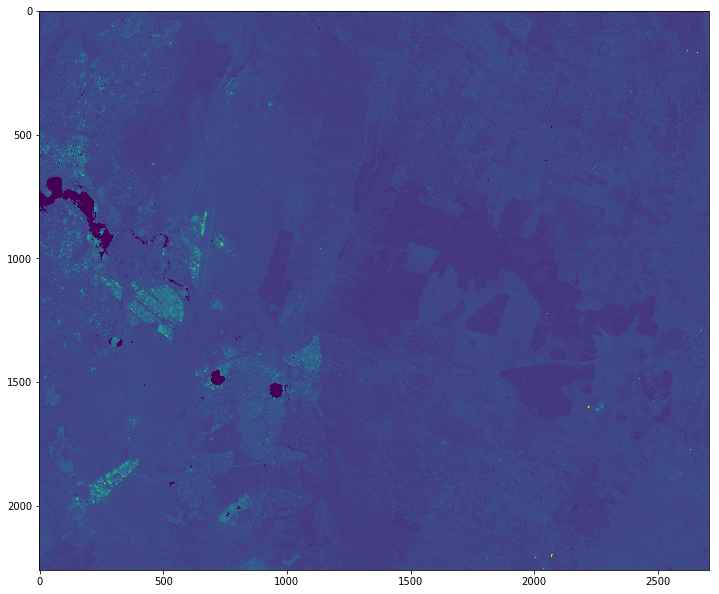

In [16]:
fig, ax = plt.subplots(figsize = (12,12))
cax = ax.imshow(GM_data[9])

plt.show()

In [17]:
#load traning data
row_number = 132960
panda_training= pd.read_csv('/g/data/u46/users/ck9738/Datasets/ML_for_smad_green/shapefiles_for_train/NCAS_trained_GM.csv',
                            usecols=(1,2,3,4,5,6,7,8,9,10,11),nrows=row_number)#
panda_training = panda_training.dropna(axis=0)
panda_training

,class,red,blue,green,rededge1,rededge2,rededge3,nir1,nir2,swir1,swir2
0,1,789.072560,569.215527,733.625553,1136.248934,2014.036523,2252.125539,2699.660338,2557.503778,1963.906536,1281.260957
1,0,643.766242,483.059501,643.795675,1011.880807,1865.895384,2112.301137,2546.564296,2367.722690,1881.406317,1133.833005
2,0,554.487748,429.235907,536.344387,929.294677,1548.239430,1754.232130,1802.979115,1999.020461,1828.330495,1127.178677
3,1,494.399595,369.002308,468.365681,815.449215,1549.396754,1771.562660,1800.859597,2005.717843,1435.026338,839.249374
4,1,624.752537,448.751666,574.516617,1024.068567,1880.864894,2108.048007,2377.732315,2384.667945,1723.681687,1098.044039
5,0,1003.272344,586.898194,776.998135,1169.846137,1649.297248,1824.135425,2196.300867,2044.883629,2233.309319,1604.715081
6,0,694.949972,494.155074,614.523703,924.691342,1484.857643,1692.559808,1940.178307,1906.416252,1804.685304,1151.453061
7,1,556.533765,426.659977,522.708025,884.760302,1487.637839,1695.410244,1969.572986,1892.404269,1663.808833,1041.874814
8,1,480.199946,366.659920,480.892626,801.774747,1340.550267,1511.387546,1561.235059,1709.195055,1581.053888,994.657781
9,1,472.188010,355.274617,480.316226,831.101493,1533.737913,1709.417173,1813.717853,1955.276127,1553.929764,972.221196


In [18]:
training_features = panda_training.as_matrix(columns=['red', 'blue', 'green', 'rededge1','rededge2', 'rededge3', 'nir1', 'nir2', 'swir1', 'swir2']) #create Array of features for training
training_class = panda_training.as_matrix(columns=['class']) #create Array of classification answer for training
training_features

/g/data/v10/public/modules/dea-env/20180629/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/g/data/v10/public/modules/dea-env/20180629/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


array([[ 789.07256047,  569.2155271 ,  733.62555348, ..., 2557.50377776,
        1963.90653621, 1281.26095655],
       [ 643.76624242,  483.05950137,  643.79567536, ..., 2367.72269019,
        1881.40631725, 1133.83300471],
       [ 554.48774796,  429.23590677,  536.3443869 , ..., 1999.02046077,
        1828.33049506, 1127.17867713],
       ...,
       [ 562.19210661,  427.77053485,  529.01159712, ..., 1748.46128619,
        1903.31071727, 1180.71227428],
       [ 518.38615812,  411.72840623,  497.91281955, ..., 1573.12456853,
        1651.85815094, 1019.30572865],
       [ 525.78569307,  439.22858322,  514.28445607, ..., 1573.94013087,
        1403.84505514,  869.2391603 ]])

In [19]:
#define machine learning algarithm 
classify = ExtraTreesClassifier(n_estimators=250, bootstrap=False, random_state=0)

classify.fit(training_features,training_class)#fit the moddle to the training data
#train

/g/data/v10/public/modules/dea-env/20180629/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [20]:
#classify area
results=classify.predict(GM_data_flat)

In [29]:
results

array([0, 0, 0, ..., 0, 0, 0])

In [21]:
print(classify.feature_importances_)

[0.1075099  0.08572219 0.0990026  0.1125742  0.10573854 0.06887302
 0.05596093 0.08633567 0.1386311  0.13965185]


In [27]:
#return results back to original shape
#2972, x: 3049
results_back = results.reshape(2259,2707)
results_xr = xr.DataArray(results_back,dims=('y', 'x'),name='results')
#results_xr = results_xr.astype('int16')
results_xr

<xarray.DataArray 'results' (y: 2259, x: 2707)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Dimensions without coordinates: y, x

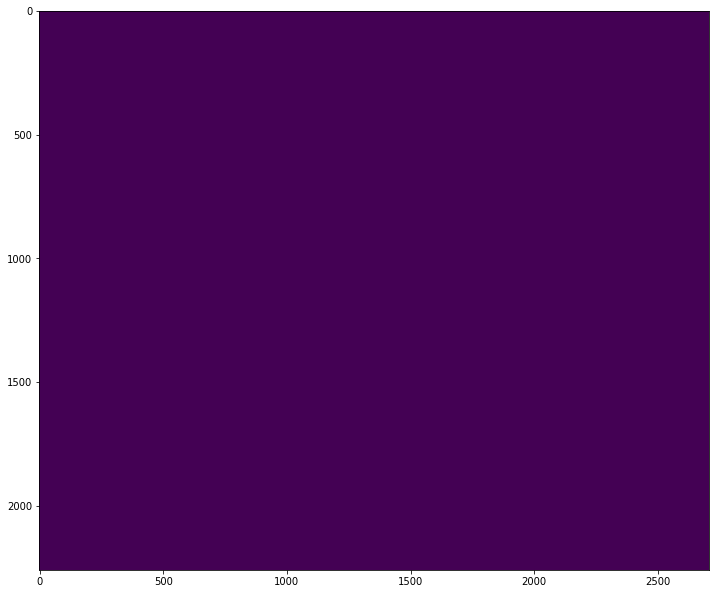

In [28]:
fig, ax = plt.subplots(figsize = (12,12))
cax = ax.imshow(results_xr)

plt.show()

In [24]:
#add classification results to dataset
##replace with Geomediam 
Sentinal_time["class"] = results_xr
Sentinal_time
#add smad/green to dataset?

<xarray.Dataset>
Dimensions:  (x: 2707, y: 2259)
Coordinates:
  * x        (x) float64 1.549e+06 1.549e+06 1.549e+06 1.549e+06 1.549e+06 ...
  * y        (y) float64 -3.951e+06 -3.951e+06 -3.951e+06 -3.951e+06 ...
    time     datetime64[ns] 2016-01-11T00:06:45.501000
Data variables:
    red      (y, x) int16 352 357 380 369 387 424 393 460 614 696 762 921 ...
    class    (y, x) int16 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
Attributes:
    crs:      EPSG:3577

In [25]:
#save dataset as netCDF to look at in QGIS
#write_geotiff(filename, dataset, profile_override=None, time_index=None)
helpers.write_geotiff('/g/data/u46/users/ck9738/Datasets/ML_for_smad_green/caneast_GM_ncass_train.tif',Sentinal_time)

In [26]:
#turn into panda Dataframe for easy plotting
results_panda = pd.DataFrame(results, columns=['class'])

results_panda['1'] = array_topanda_s(data_smad_green[0])
results_panda['2'] = array_topanda_s(data_smad_green[1])
results_panda['3'] = array_topanda_s(data_smad_green[2])
#results_panda= results_panda.dropna(axis=0, how='any')
results_panda

NameError: name 'array_topanda_s' is not defined

In [ ]:
"""colours_class = pd.Series(results)
#colours_class = colours_class.replace(to_replace=[2,1,0],value=['blue','green','orange'])
colours_class = colours_class.replace(to_replace=[0,1,2],value=['darkseagreen','khaki',
                                                                    'forestgreen'])#for 5 classes
colours_class = colours_class.as_matrix()
colours_class"""

In [ ]:
"""results_panda.plot.scatter('1','2',c=colours_class, figsize=(12,12), alpha=0.1)
plt.title('scatter of classification result, smad vs max green')"""